# Лабораторная работа №1

## Описание датасета

Данные содержат 400 записей о покупателях.

In [1]:
import pandas as pd

In [2]:
DATASET = pd.read_csv('../01/dataset1.csv').dropna()

In [3]:
DATASET.head()

,CustomerID,Gender,Age,Annual_Income,Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Проверка на пропуски в колонках:

In [4]:
DATASET.isnull().sum().to_frame('Пропусков в колонках')

,Пропусков в колонках
CustomerID,0
Gender,0
Age,0
Annual_Income,0
Spending_Score,0


In [5]:
DATASET.min().to_frame('Минимальные значения')

,Минимальные значения
CustomerID,1
Gender,Female
Age,18
Annual_Income,15
Spending_Score,1


In [6]:
DATASET.max().to_frame('Максимальные значения')

,Максимальные значения
CustomerID,400
Gender,Male
Age,70
Annual_Income,137
Spending_Score,99


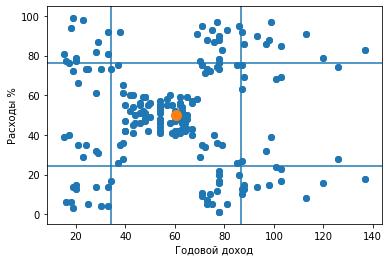

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def mean_std(series):
    return series.mean(), series.std()

Annual_Income = DATASET['Annual_Income']
Spending_Score = DATASET['Spending_Score']

x_mean, x_std = mean_std(Annual_Income)
y_mean, y_std = mean_std(Spending_Score)

plt.axvline(x_mean - x_std)
plt.axvline(x_mean + x_std)
plt.axhline(y_mean - y_std)
plt.axhline(y_mean + y_std)
plt.scatter(Annual_Income, Spending_Score)
plt.scatter(x_mean, y_mean, s=100)
plt.xlabel('Годовой доход')
plt.ylabel('Расходы %')
plt.show()

На графикe выше изображено распределение измерений на плоскости. Вертикальные и горизонтальные линии обозначают стандартные отклонения от среднего значения, отмеченного точкой в середине графика.

### Кластеризация k-means
Для кластеризации будем использовать библиотеку sklearn. Библиотечная реализация k-means по-умолчанию выполняет алгоритм несколько раз с различными центрами, выбирая в качестве конечного результата кластеры с наименьшим внутрикластерным отклонением. Число повторений можно переопределить параметром n_init, по-умолчанию он равен 10. Способ выбора центроидов задаётся параметром init. По-умолчанию используется улучшенный метод k-means++, но сначала воспользуется случайным выбором.

Выполним кластеризацию с разным желаемым количеством кластеров и посмотрим на изменение среднего внутрикластерного отклонения.

In [8]:
data = DATASET.loc[:, ['Annual_Income', 'Spending_Score']]

In [9]:
from sklearn.cluster import KMeans

In [10]:
def cluster_with_k_means(n_clusters, init='random'):
    kmeans = KMeans(n_clusters=n_clusters, init=init)
    return kmeans.fit(data)

n_clusters_range = range(2, 10)
clustered_data = {n_clusters:cluster_with_k_means(n_clusters) for n_clusters in n_clusters_range}
clustered_data_plus = {n_clusters:cluster_with_k_means(n_clusters, 'k-means++') for n_clusters in n_clusters_range}

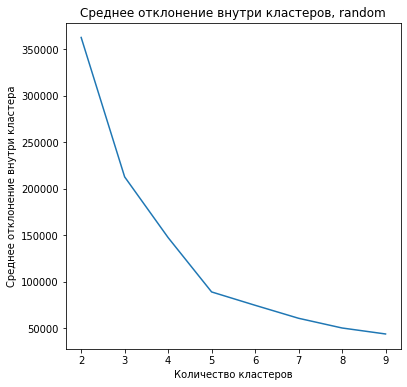

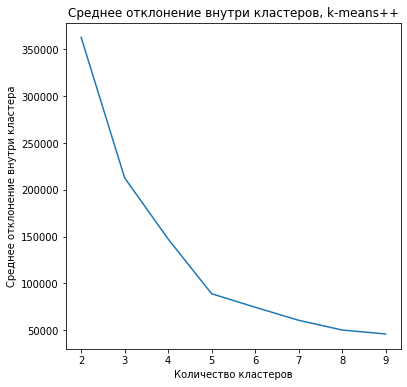

In [11]:
def draw_inertia_plot(clustered, method):
    clusters_inertia = [clusters.inertia_ for clusters in clustered.values()]
    plt.figure(figsize=(6, 6))
    plt.plot(n_clusters_range, clusters_inertia)
    plt.title(f'Среднее отклонение внутри кластеров, {method}')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Среднее отклонение внутри кластера')
    plt.show()

draw_inertia_plot(clustered_data, 'random')
draw_inertia_plot(clustered_data_plus, 'k-means++')

На графике видим, что скорость уменьшения отклонения падает после 5 кластеров. При использовании метода k-means++ график ровный и число 5 является стабильно оптимальным, а при случайном выборе центроидов оно меняется от 5 до 7.

Изучим показатели средние показатели силуэтов по всем точкам при различном количестве кластеров.

In [12]:
from sklearn import metrics

In [13]:
def silhoutte_score_for_clusters(clustered_data):
    return metrics.silhouette_score(X=data, labels=clustered_data.labels_)

silhouttes = [silhoutte_score_for_clusters(clusters) for clusters in clustered_data.values()]
silhouttes_plus = [silhoutte_score_for_clusters(clusters) for clusters in clustered_data_plus.values()]

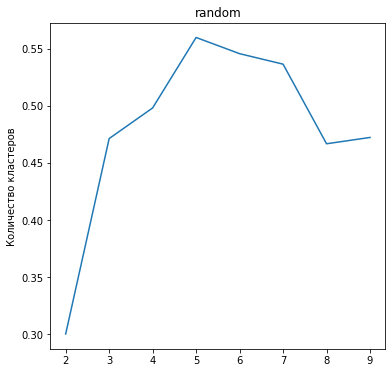

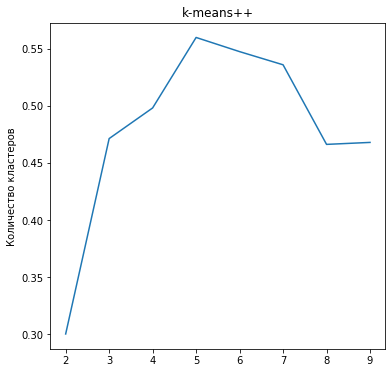

In [14]:
def draw_avg_silhoutte_plot(silhouttes, method):
    plt.figure(figsize=(6, 6))
    plt.plot(n_clusters_range, silhouttes)
    plt.title(method)
    plt.ylabel('Среднее значение силуэта среди всех точек')
    plt.ylabel('Количество кластеров')
    plt.show()

draw_avg_silhoutte_plot(silhouttes, 'random')
draw_avg_silhoutte_plot(silhouttes_plus, 'k-means++')

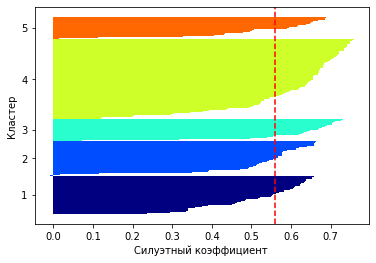

In [42]:
X = data
km = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter = 300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples 
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels .shape[0] 
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower , y_ax_upper = 0 , 0
yticks = []
for i , c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters) # float(i) для совместимости с Python 2.7 
    plt.barh(range(y_ax_lower, y_ax_upper) , c_silhouette_vals , height = 1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower +y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals) 
silhouette_avg = np.mean(silhouette_vals) 
plt.axvline(silhouette_avg, color= "red", linestyle="--") 
plt.yticks(yticks , cluster_labels + 1)
plt.ylabel('Кластер') 
plt.xlabel('Силуэтный коэффициент ') 
plt.show()


Оценим визуально кластеры, получившиеся при разном параметре.

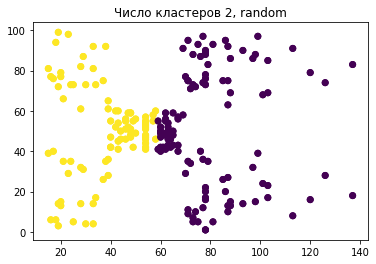

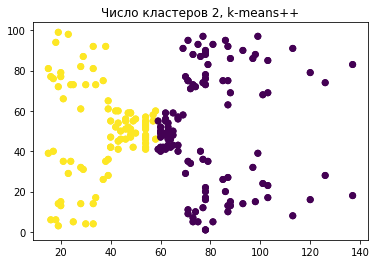

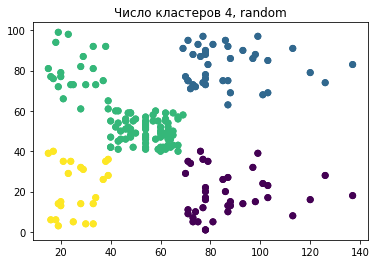

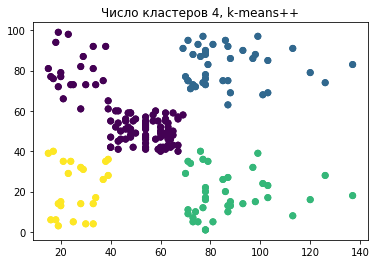

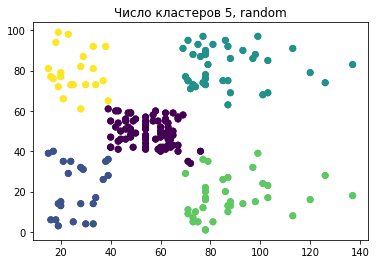

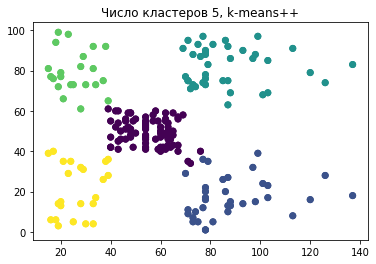

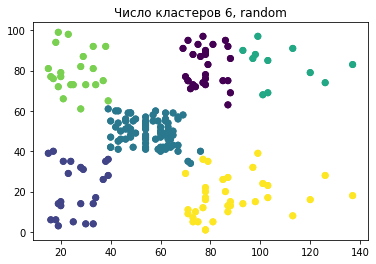

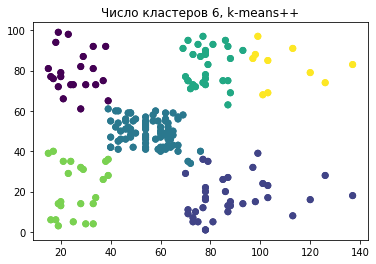

In [15]:
def highlight_clusters(x, y, labels):
    plt.scatter(x, y, c=labels)
    plt.show()
    
def draw_n_clusters(clustered_data, n, method):
    labels = clustered_data[n].labels_
    plt.title(f'Число кластеров {n}, {method}')
    highlight_clusters(Annual_Income, Spending_Score, labels)    

    
draw_n_clusters(clustered_data, 2, 'random')
draw_n_clusters(clustered_data_plus, 2, 'k-means++')

draw_n_clusters(clustered_data, 4, 'random')
draw_n_clusters(clustered_data_plus, 4, 'k-means++')

draw_n_clusters(clustered_data, 5, 'random')
draw_n_clusters(clustered_data_plus, 5, 'k-means++')

draw_n_clusters(clustered_data, 6, 'random')
draw_n_clusters(clustered_data_plus, 6, 'k-means++')


При кластеризации на 5 кластеров оба метода выбора центроидов показали себя отлично.

### Иерархическая кластеризация

Для кластеризации будем использовать библиотеку scipy и seaborn для тепловой карты. Ниже приведено сравнение разбиения на кластеры при разных способах измерения расстояния между кластерами - single, complete, average, ward.

In [16]:
from scipy.cluster import hierarchy
from seaborn import clustermap

In [17]:
def draw_dendrogram(method):
    dendrogram = hierarchy.dendrogram(
        hierarchy.linkage(
            data,
            method=method
        ),
        truncate_mode='lastp',
        p=15
    )
    plt.show()


def draw_heatmap(method):
    clustermap(data, method=method)
    plt.show()
    

def illustrate_method(method):
    draw_dendrogram(method)
    draw_heatmap(method)

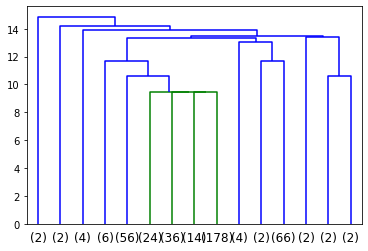

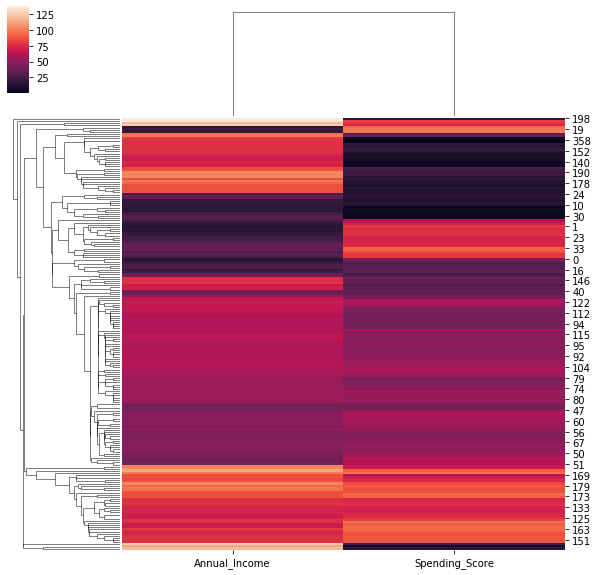

In [18]:
illustrate_method('single')

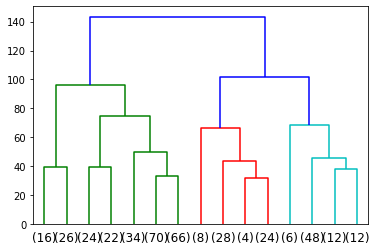

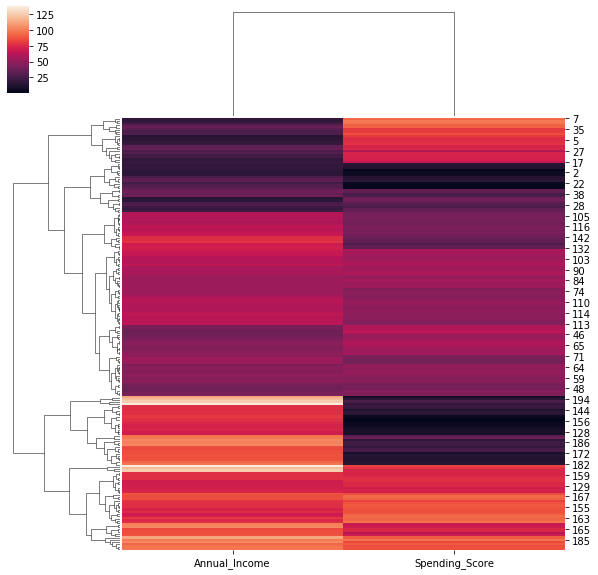

In [19]:
illustrate_method('complete')

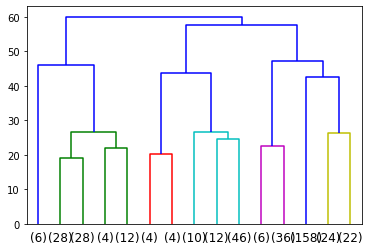

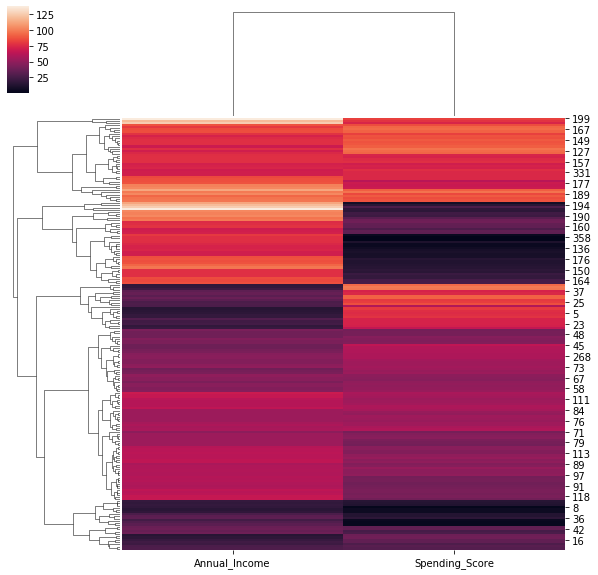

In [20]:
illustrate_method('average')

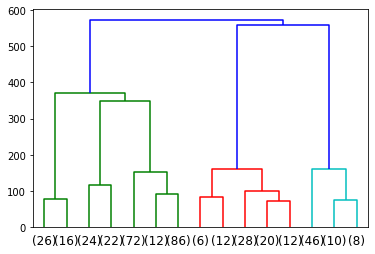

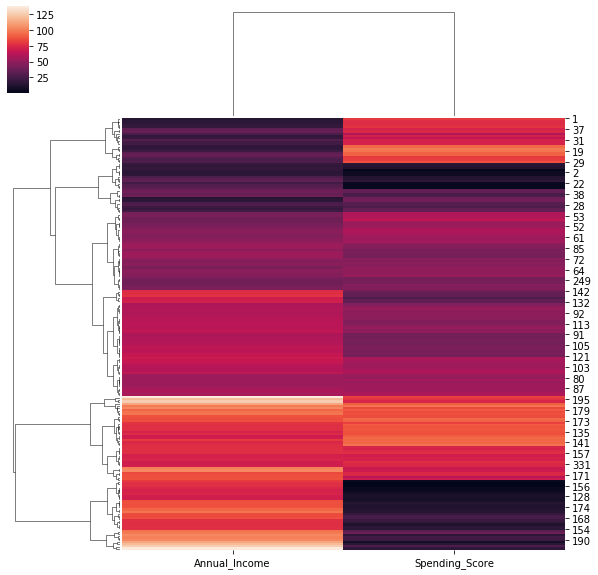

In [21]:
illustrate_method('ward')

### Кластеризация DBSCAN

Для кластеризации методом DBSCAN воспользуемся реализацией из библиотеки sklearn.
Модель предоставляет 2 основных параметра:
- eps - максимальное расстояние между двумя точками, при котором они распознаются как соседи
- min_samples - минимальное количество точек, которые могут образовать кластер

Посмотрим, как изменяется среднее попарное расстояние между точками при различном eps.

In [22]:
from sklearn.cluster import DBSCAN

In [23]:
from sklearn.metrics import pairwise_distances

In [43]:
data_pairwise_distances = pairwise_distances(data[0:200])

In [44]:
min_samples = 3
mean_distances = [
    sum(sorted(distances_for_point)[:min_samples])/min_samples
    for distances_for_point in data_pairwise_distances
]
mean_distances.sort()

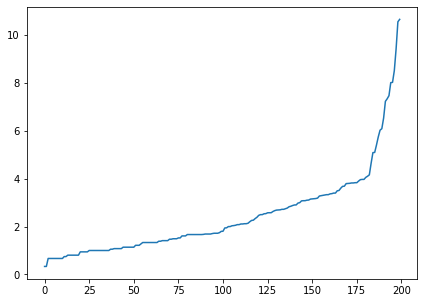

In [45]:
plt.figure(figsize=(7,5))
plt.plot(mean_distances)
plt.show()

In [27]:
def draw_clusters_for_eps(eps, x, y):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    _ = dbscan.fit(data)
    
    filtered_x = [x for i, x in enumerate(x) if dbscan.labels_[i] != -1]
    filtered_y = [x for i, x in enumerate(y) if dbscan.labels_[i] != -1]
    filtered_labels = [label for label in dbscan.labels_ if label != -1]
    
    highlight_clusters(filtered_x, filtered_y, filtered_labels)

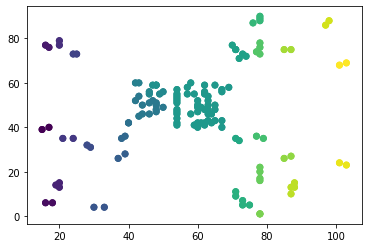

In [28]:
draw_clusters_for_eps(3, Annual_Income, Spending_Score)

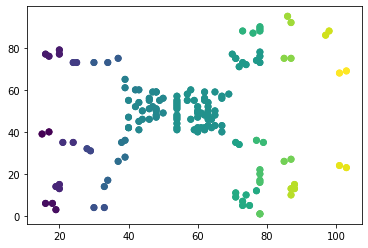

In [29]:
draw_clusters_for_eps(4, Annual_Income, Spending_Score)

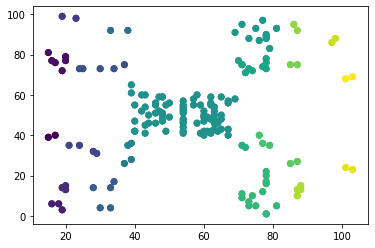

In [30]:
draw_clusters_for_eps(5, Annual_Income, Spending_Score)

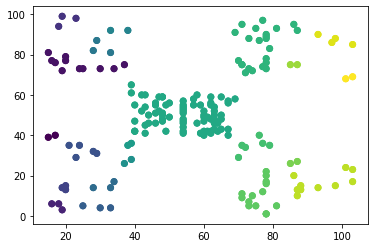

In [31]:
draw_clusters_for_eps(6, Annual_Income, Spending_Score)

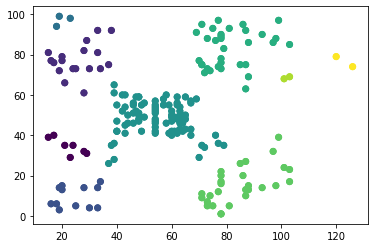

In [32]:
draw_clusters_for_eps(9.4, Annual_Income, Spending_Score)

# Заключение

С выбранным датасетом лучше всего себя проявил алгоритм k-means. Этому способствовало то, что основные видимые кластера были хорошо разделимы прямыми на плоскости, что соответствует основному назначению алгоритма.

DBScan не смог выявить злостных нарушителей справа только при очень большом eps, из-за чего кластеры в левой части соединились в один.

Иерархическая кластеризация эффективно разделяла данные на два кластера по расстоянию (левый и правый) при всех рассмотренных методах измерения дистанции между кластерами. При этом кластеры по превышению скорости (низ и верх), судя по тепловым картам, разделялись плохо.